# Final Project

In [14]:
# import libraries (notice that we have included some new libraries that we will be using in this lab)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm
import datetime
from numbers import Number

In [15]:
stationName = "Vancouver Harbour" # Vancouver Harbour # Tofino

slev_file_name = 'data/VanHarbourSeaLevelData.csv' # 'VanHarbourSeaLevelData.csv' # 'TofinoSeaLevelData.csv'
temperature_file_name = 'data/VanHarbourTempData.csv' # 'VanHarbourTempData.csv' # 'TofinoTempData.csv'

Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  1
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad!  2
Bad data bad! 

Text(0.5, 1.0, 'Mean Monthly Sea level Anomaly Time Series at Vancouver Harbour (1940-2022)')

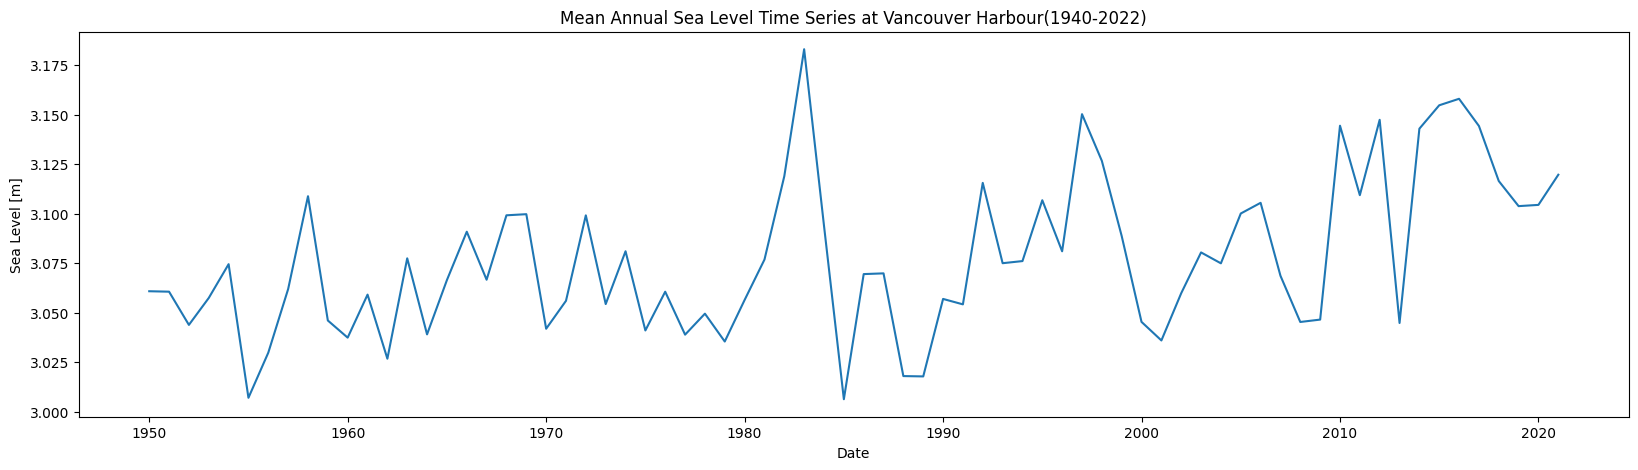

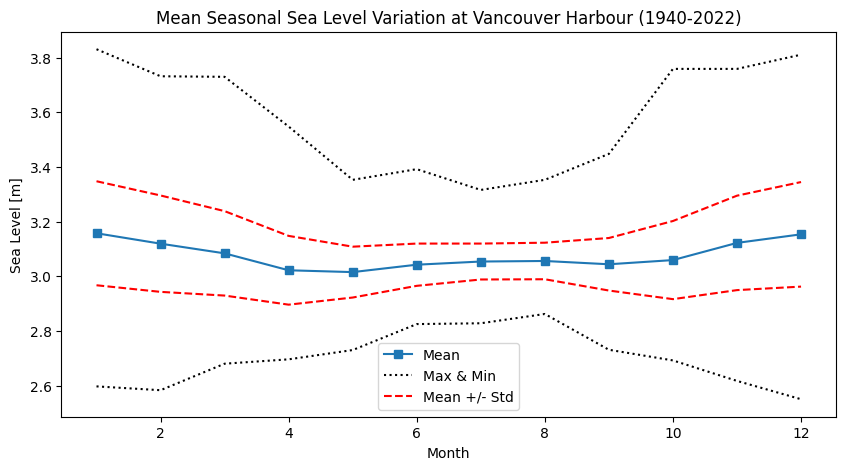

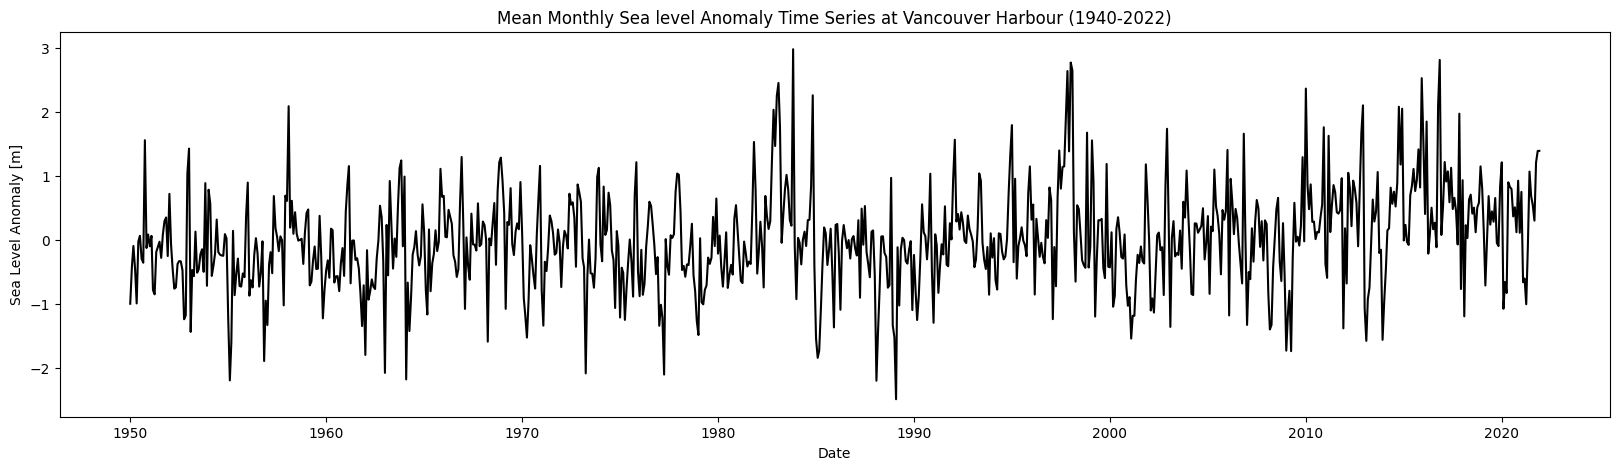

In [16]:
df = pd.read_csv(slev_file_name, sep=',', parse_dates=['Date'])

########## Raw Daily mean:
# Convert to datetime
x = pd.to_datetime(df['Date'])
y = df['sealevel']

previousMonth = 1
for index, row in df.iterrows():
    # if (previousMonth == 12):
    #     previousMonth = -1
    
    if (row.Date.month == 1 and previousMonth == 12):
        print("New year")
    elif (row.Date.month != previousMonth or row.Date.month - 1 != previousMonth):
        print("Bad data bad! ", previousMonth)
    # else: (row.Date.month != previousMonth):
    #     print("Bad data bad!")
    # print(row.Date.month)
    previousMonth = row.Date.month
    # print(row['c1'], row['c2'])

# change the size of the figure
# plt.figure(figsize=(20, 5))
# plt.plot(x, y)
# plt.xlabel('Date')
# plt.ylabel('Sea Level (metres)')
# plt.title('Mean Daily Sea Level Time Series at Vancouver Harbour(1940-2022)')


########## Monthly mean:
sea_month = df.groupby(df.Date.dt.to_period('M'))['sealevel'].mean()
sea_month = sea_month.to_frame()
sea_month = sea_month.reset_index()
# covert sea_month to a pandas dataframe
monthly_sea_level = sea_month['sealevel']
months = sea_month['Date'].dt.to_timestamp()

# plt.figure(figsize=(20,5))
# plt.plot(months, monthly_sea_level)
# plt.xlabel('Date')
# plt.ylabel('Sea Level [m]')
# plt.title('Mean Monthly Sea Level Time Series at Vancouver Harbour(1940-2022)')


########## Yearly mean:
sea_year = df.groupby(df.Date.dt.to_period('Y'))['sealevel'].mean()
sea_year = sea_year.to_frame()
sea_year = sea_year.reset_index()
yearly_sea_level = sea_year['sealevel']
date = sea_year['Date'].dt.to_timestamp()

plt.figure(figsize=(20,5))
plt.plot(date, yearly_sea_level)
plt.xlabel('Date')
plt.ylabel('Sea Level [m]')
plt.title('Mean Annual Sea Level Time Series at Vancouver Harbour(1940-2022)')


########## Lab called it: "Mean Monthly Temperature Record at Bella Bella Station 1959-2018":
#  Plot mean monthly sea level
#  Group by month

monthly_mean_temp = df.groupby(df.Date.dt.month)['sealevel'].mean()
monthly_max_temp = df.groupby(df.Date.dt.month)['sealevel'].max()
monthly_min_temp = df.groupby(df.Date.dt.month)['sealevel'].min()
monthly_std_temp = df.groupby(df.Date.dt.month)['sealevel'].std()
plt.figure(figsize=(10, 5))

plt.plot(monthly_mean_temp, marker = 's', label = 'Mean')
plt.plot(monthly_min_temp, ':', color='black', label = '_nolegend_')
plt.plot(monthly_max_temp, ':', color='black', label='Max & Min')
plt.plot(monthly_mean_temp + monthly_std_temp, '--', color='red', label='Mean +/- Std')
plt.plot(monthly_mean_temp - monthly_std_temp, '--' ,color='red', label = '_nolegend_')
plt.legend()

plt.xlabel('Month')
plt.ylabel('Sea Level [m]')
plt.title('Mean Seasonal Sea Level Variation at ' + stationName + ' (1940-2022)')


########## Anomaly time series: Lab called it: 'Mean Monthly Temperature Anomaly Time-Series at Bella Bella Station 1959-2018'
tiled_mean_temp = np.tile(monthly_mean_temp, 72)
plt.figure(figsize=(20,5))

slev_anomaly_data = monthly_sea_level - tiled_mean_temp[:863]
plt.plot(months, slev_anomaly_data*10, color='black')
# plt.plot(monthly_dates_full, temp_anomaly_data, color='red')
plt.xlabel('Date')
plt.ylabel('Sea Level Anomaly [m]')
plt.title('Mean Monthly Sea level Anomaly Time Series at ' + stationName + ' (1940-2022)')


Text(0.5, 1.0, 'Mean Monthly Temperature Anomaly Time Series at Vancouver Harbour (1940-2022)')

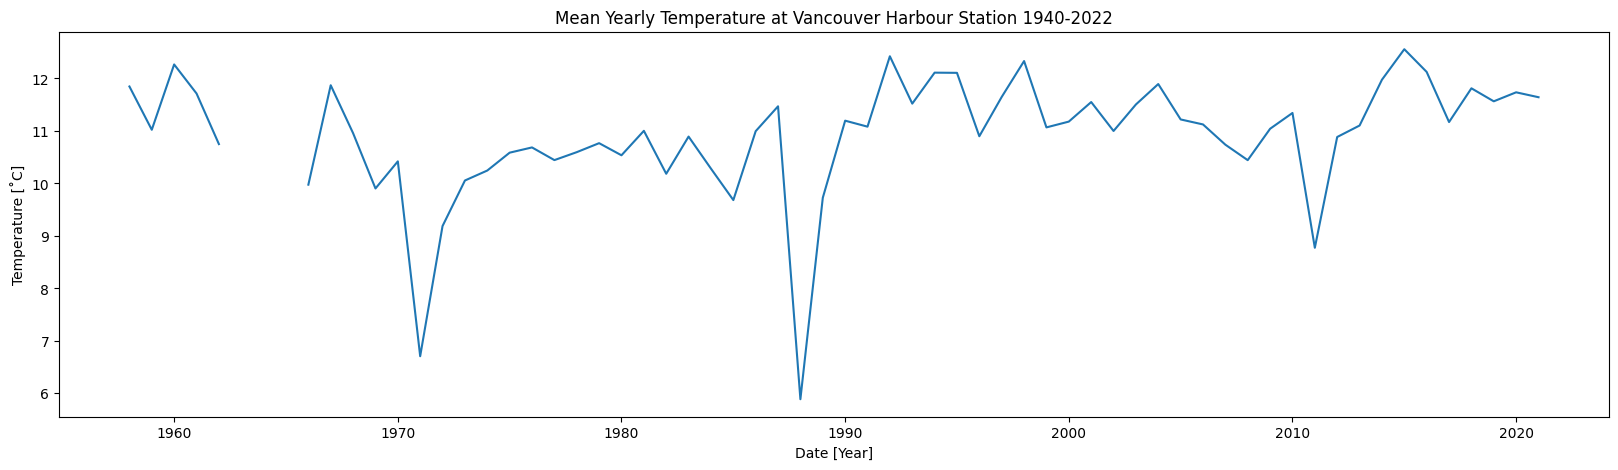

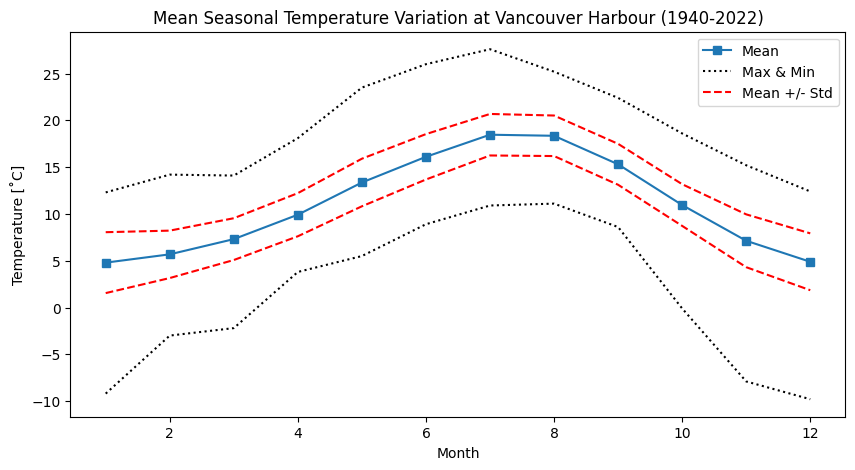

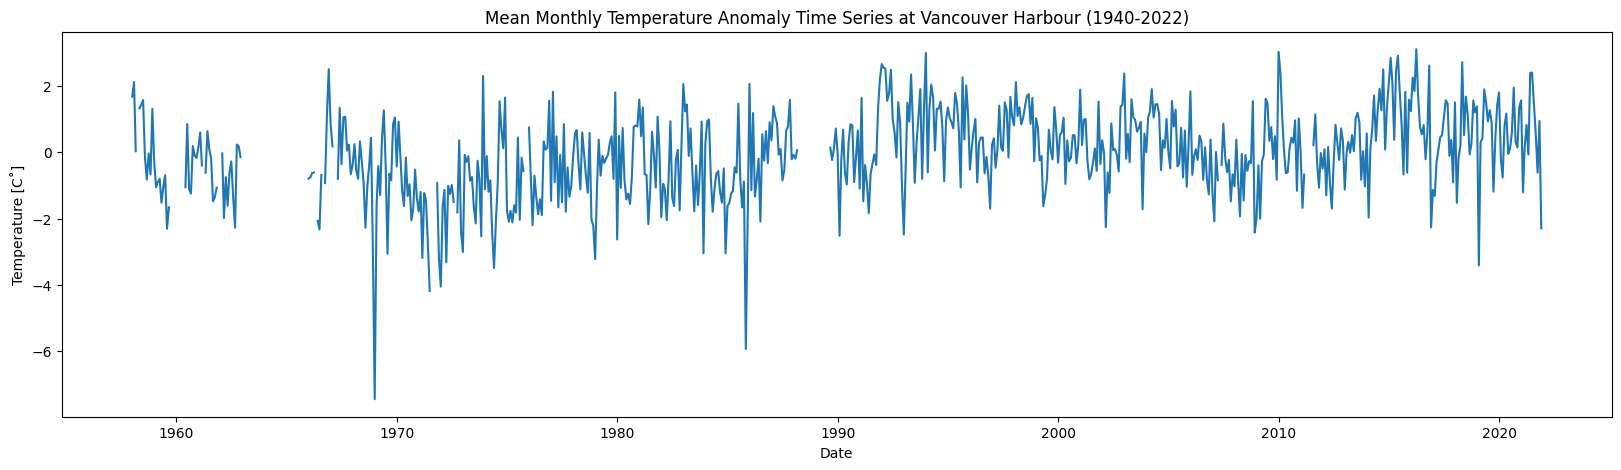

In [17]:
tempDataDF = pd.read_csv(temperature_file_name, sep=',', parse_dates=['Date'])

figsizes = [20,5]

########## Mean Daily:
# fDaily = plt.figure(figsize=figsizes)
# plt.plot(tempDataDF.Date, tempDataDF.MeanTemp)
# plt.title('Mean Daily Temperature at Vancouver Harbour Station 1940-2022')
# plt.xlabel('Date [Year]', fontsize=10)
# plt.ylabel('Temperature [˚C]', fontsize=10)
# # fDaily.savefig("MeanDailyTemp.pdf", bbox_inches='tight')



########## Mean Monthly:
groupByDF2_monthly = tempDataDF.groupby(pd.PeriodIndex(tempDataDF.Date.dt.to_period('M')))["MeanTemp"] # JH: Group data by month over 1959-2018

original_monthly_temp_mean = groupByDF2_monthly.mean() # JH: Get group's mean
monthly_temp_mean = original_monthly_temp_mean.to_frame() # JH: Have to make it a dataframe to use function below
monthly_temp_mean = monthly_temp_mean.reset_index() # JH: Fix things behind the scenes silly python
monthly_dates_full = monthly_temp_mean["Date"].dt.to_timestamp() # JH: Get the x values which is all of the months

# fMonthly = plt.figure(figsize=figsizes)
# plt.plot(monthly_dates_full, monthly_temp_mean["MeanTemp"])
# plt.title('Mean Monthly Temperature at Vancouver Harbour Station 1940-2022')
# plt.xlabel('Date [Year]', fontsize=10)
# plt.ylabel('Temperature [˚C]', fontsize=10)
# # fMonthly.savefig("MeanMonthlyTemp.pdf", bbox_inches='tight')



########## Mean Yearly:
groupByDF2_yearly = tempDataDF.groupby(pd.PeriodIndex(tempDataDF.Date.dt.to_period('Y')))["MeanTemp"] # JH: Group data by month over 1959-2018

original_yearly_temp_mean = groupByDF2_yearly.mean() # JH: Get group's mean
yearly_temp_mean = original_yearly_temp_mean.to_frame() # JH: Have to make it a dataframe to use function below
yearly_temp_mean = yearly_temp_mean.reset_index() # JH: Fix things behind the scenes silly python
yearly_dates_full = yearly_temp_mean["Date"].dt.to_timestamp() # JH: Get the x values which is all of the months

fYear = plt.figure(figsize=figsizes)
plt.plot(yearly_dates_full, yearly_temp_mean["MeanTemp"])
plt.title('Mean Yearly Temperature at Vancouver Harbour Station 1940-2022')
plt.xlabel('Date [Year]', fontsize=10)
plt.ylabel('Temperature [˚C]', fontsize=10)
# fYear.savefig("MeanYearlyTemp.pdf", bbox_inches='tight')


########## Lab called it: "Mean Monthly Temperature Record at Bella Bella Station 1959-2018":
monthly_mean_temp = tempDataDF.groupby(tempDataDF.Date.dt.month)["MeanTemp"].mean()
monthly_max_temp = tempDataDF.groupby(tempDataDF.Date.dt.month)["MeanTemp"].max()
monthly_min_temp = tempDataDF.groupby(tempDataDF.Date.dt.month)["MeanTemp"].min()
monthly_std_temp = tempDataDF.groupby(tempDataDF.Date.dt.month)["MeanTemp"].std()
plt.figure(figsize=(10, 5))

plt.plot(monthly_mean_temp, marker = 's', label = 'Mean')
plt.plot(monthly_min_temp, ':', color='black', label = '_nolegend_')
plt.plot(monthly_max_temp, ':', color='black', label='Max & Min')
plt.plot(monthly_mean_temp + monthly_std_temp, '--', color='red', label='Mean +/- Std')
plt.plot(monthly_mean_temp - monthly_std_temp, '--' ,color='red', label = '_nolegend_')
plt.legend()

plt.xlabel('Month')
plt.ylabel('Temperature [˚C]')
plt.title('Mean Seasonal Temperature Variation at ' + stationName + ' (1940-2022)')


########## Anomaly time series: Lab called it: 'Mean Monthly Temperature Anomaly Time-Series at Bella Bella Station 1959-2018'
tiled_mean_temp = np.tile(monthly_mean_temp, 72)
plt.figure(figsize=(20,5))

temp_anomaly_data = monthly_temp_mean["MeanTemp"] - tiled_mean_temp
plt.plot(monthly_dates_full, temp_anomaly_data)
plt.xlabel('Date')
plt.ylabel('Temperature [C˚]')
plt.title('Mean Monthly Temperature Anomaly Time Series at ' + stationName + ' (1940-2022)')



Text(0.5, 1.0, 'Mean Monthly Sea level Anomaly Time Series at Vancouver Harbour (1940-2022)')

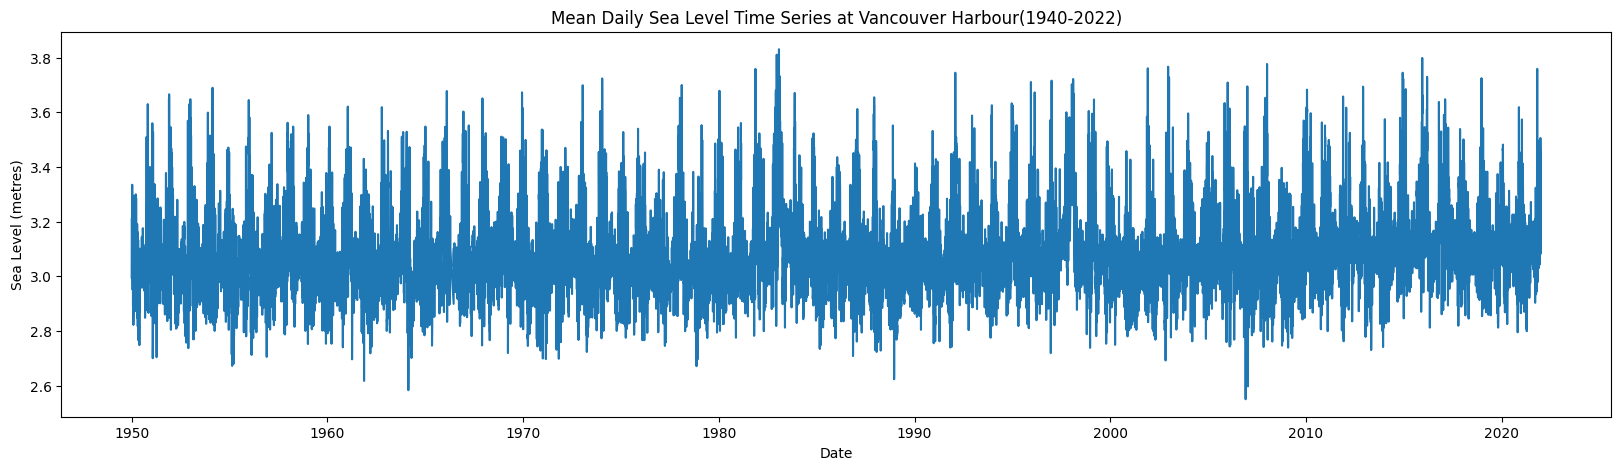

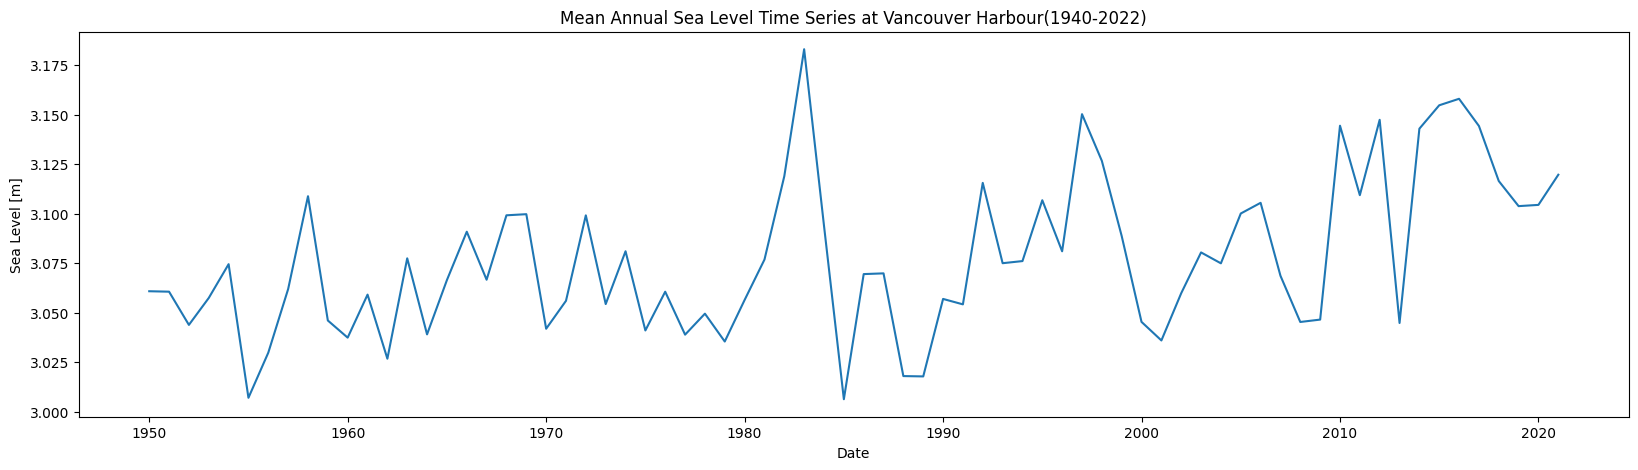

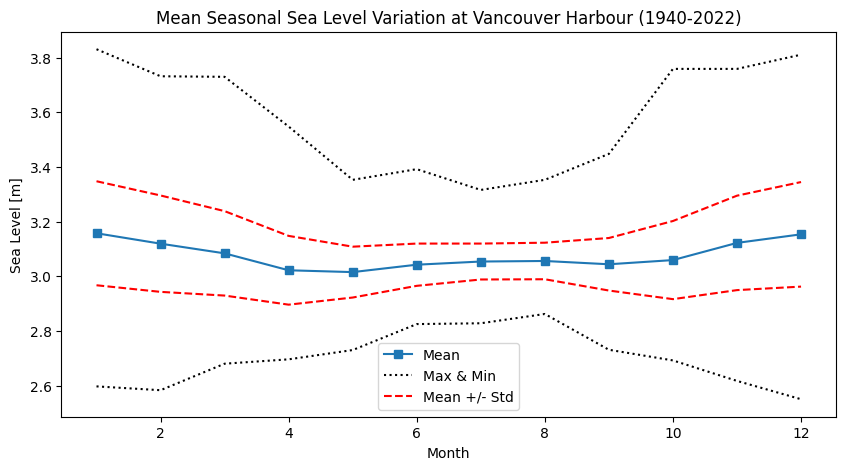

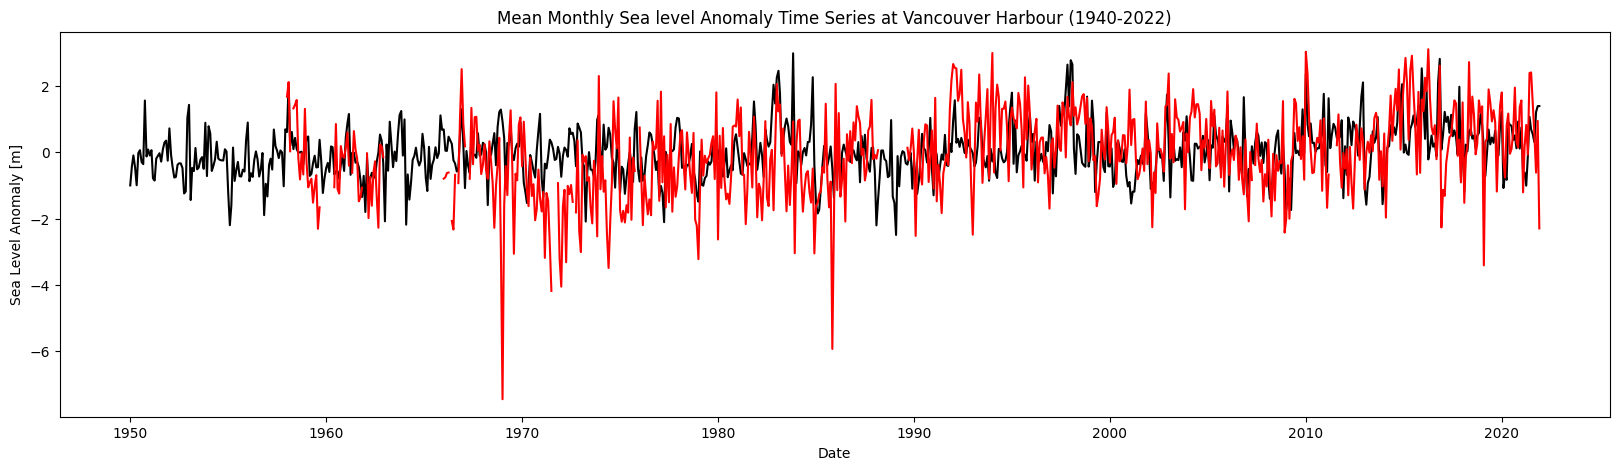

In [18]:
sealev_file_name = 'data/VanHarbourSeaLevelData.csv' # 'VanHarbourSeaLevelData.csv' # 'TofinoSeaLevelData.csv'
df = pd.read_csv(sealev_file_name, sep=',', parse_dates=['Date'])

########## Raw Daily mean:

# Convert to datetime
x = pd.to_datetime(df['Date'])
y = df['sealevel']

# change the size of the figure
plt.figure(figsize=(20, 5))
plt.plot(x, y)
plt.xlabel('Date')
plt.ylabel('Sea Level (metres)')
plt.title('Mean Daily Sea Level Time Series at Vancouver Harbour(1940-2022)')


########## Monthly mean:
sea_month = df.groupby(df.Date.dt.to_period('M'))['sealevel'].mean()
sea_month = sea_month.to_frame()
sea_month = sea_month.reset_index()
# covert sea_month to a pandas dataframe
monthly_sea_level = sea_month['sealevel']
months = sea_month['Date'].dt.to_timestamp()

# plt.figure(figsize=(20,5))
# plt.plot(months, monthly_sea_level)
# plt.xlabel('Date')
# plt.ylabel('Sea Level [m]')
# plt.title('Mean Monthly Sea Level Time Series at Vancouver Harbour(1940-2022)')


########## Yearly mean:
sea_year = df.groupby(df.Date.dt.to_period('Y'))['sealevel'].mean()
sea_year = sea_year.to_frame()
sea_year = sea_year.reset_index()
yearly_sea_level = sea_year['sealevel']
date = sea_year['Date'].dt.to_timestamp()

plt.figure(figsize=(20,5))
plt.plot(date, yearly_sea_level)
plt.xlabel('Date')
plt.ylabel('Sea Level [m]')
plt.title('Mean Annual Sea Level Time Series at Vancouver Harbour(1940-2022)')


########## Lab called it: "Mean Monthly Temperature Record at Bella Bella Station 1959-2018":
#  Plot mean monthly sea level
#  Group by month

monthly_mean_temp = df.groupby(df.Date.dt.month)['sealevel'].mean()
monthly_max_temp = df.groupby(df.Date.dt.month)['sealevel'].max()
monthly_min_temp = df.groupby(df.Date.dt.month)['sealevel'].min()
monthly_std_temp = df.groupby(df.Date.dt.month)['sealevel'].std()
plt.figure(figsize=(10, 5))

plt.plot(monthly_mean_temp, marker = 's', label = 'Mean')
plt.plot(monthly_min_temp, ':', color='black', label = '_nolegend_')
plt.plot(monthly_max_temp, ':', color='black', label='Max & Min')
plt.plot(monthly_mean_temp + monthly_std_temp, '--', color='red', label='Mean +/- Std')
plt.plot(monthly_mean_temp - monthly_std_temp, '--' ,color='red', label = '_nolegend_')
plt.legend()

plt.xlabel('Month')
plt.ylabel('Sea Level [m]')
plt.title('Mean Seasonal Sea Level Variation at ' + stationName + ' (1940-2022)')


########## Anomaly time series: Lab called it: 'Mean Monthly Temperature Anomaly Time-Series at Bella Bella Station 1959-2018'
tiled_mean_temp = np.tile(monthly_mean_temp, 72)
plt.figure(figsize=(20,5))

slev_anomaly_data = monthly_sea_level - tiled_mean_temp[:863]
plt.plot(months, slev_anomaly_data*10, color='black')
plt.plot(monthly_dates_full, temp_anomaly_data, color='red')
plt.xlabel('Date')
plt.ylabel('Sea Level Anomaly [m]')
plt.title('Mean Monthly Sea level Anomaly Time Series at ' + stationName + ' (1940-2022)')




In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# reshape the data to be 2D
x = temp_anomaly_data[:895].values.reshape(-1,1)
y = slev_anomaly_data.values.reshape(-1,1)


# drop NaN values

# create a mask for NaN values
mask = np.isnan(x) | np.isnan(y)
# drop the NaN values
x = x[~mask]
y = y[~mask]

# reshape array
x = x.reshape(-1,1)
y = y.reshape(-1,1)
# create the model
model = LinearRegression()
# fit the model
model.fit(x, y)
# make predictions
ypred = model.predict(x)
# plot on the same figure

# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
# print r^2 value
print('R^2: ', r2_score(y, ypred))

plt.figure(figsize=(20,5))
plt.scatter(x, y)
plt.plot(x, ypred, color='red')
plt.ylabel('Sea Level Anomaly [m]')
plt.xlabel('Temperature Anomaly [˚C]')
plt.title('Sea Level Anomaly vs Temperature Anomaly at ' + stationName + ' (1940-2022)')

ValueError: operands could not be broadcast together with shapes (864,1) (863,1) 